epoch:0, Train Loss:0.4902, Train Acc:0.890708, Test Loss:0.1615, Test Acc:0.9563
epoch:1, Train Loss:0.1632, Train Acc:0.956990, Test Loss:0.3933, Test Acc:0.9699
epoch:2, Train Loss:0.1103, Train Acc:0.971682, Test Loss:0.3835, Test Acc:0.9768
epoch:3, Train Loss:0.0844, Train Acc:0.976946, Test Loss:0.1159, Test Acc:0.9797
epoch:4, Train Loss:0.0676, Train Acc:0.981810, Test Loss:0.0165, Test Acc:0.9800
epoch:5, Train Loss:0.0505, Train Acc:0.987657, Test Loss:0.0078, Test Acc:0.9824
epoch:6, Train Loss:0.0447, Train Acc:0.988989, Test Loss:0.1830, Test Acc:0.9813
epoch:7, Train Loss:0.0387, Train Acc:0.990822, Test Loss:0.1954, Test Acc:0.9821
epoch:8, Train Loss:0.0371, Train Acc:0.991604, Test Loss:0.1321, Test Acc:0.9822
epoch:9, Train Loss:0.0331, Train Acc:0.992454, Test Loss:0.0619, Test Acc:0.9824
epoch:10, Train Loss:0.0280, Train Acc:0.993687, Test Loss:0.0470, Test Acc:0.9833
epoch:11, Train Loss:0.0270, Train Acc:0.994220, Test Loss:0.0761, Test Acc:0.9829
epoch:12, Trai

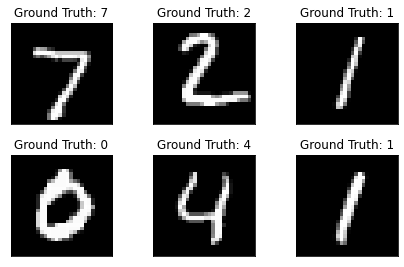

In [5]:
import numpy as np
import torch
#导入Pytorch内置的mnist数据集
from torchvision.datasets import mnist
# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

"""
定义超参数
"""
train_batch_size = 64
test_batch_size = 128
lr = 0.01
num_epoches = 20
momentum = 0.5

"""
下载数据集并预处理
"""
# 定义预处理函数，预处理依次放在Compose函数中
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
# 下载数据，并预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
# dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

"""
可视化源数据
"""
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader) # 遍历对象
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    
"""
构建模型
"""
# 构建网络
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, n_hidden_3, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, n_hidden_3), nn.BatchNorm1d(n_hidden_3))
        self.layer4 = nn.Sequential(nn.Linear(n_hidden_3, out_dim))
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x
# 实例化网络
device = torch.device("cpu")
model = Net(28*28, 300, 100, 100, 10)
model.to(device) # 发送到上面指定的CPU或者GPU上运算
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

"""
训练模型
"""
losses = []
acces = []
eval_losses = []
eval_acces = []
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr'] *= 0.5
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集看效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        # 计算误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch:{}, Train Loss:{:.4f}, Train Acc:{:4f}, Test Loss:{:.4f}, Test Acc:{:.4f}' .format(epoch, train_loss/len(train_loader), train_acc/len(train_loader), eval_loss/len(test_loader), eval_acc/len(test_loader) ))